# Multi-step research agent

The research agent is inspired by [this project](https://github.com/rahulnyk/research_agent) and [BabyAGI](https://github.com/yoheinakajima/babyagi/tree/main).

The idea is as follows: we start with a research question and some source of data we can retrieve from. We retrieve the data relevant for the original question, but then instead of feeding it into the LLM prompt to answer the question, like a conventional RAG would do, we use it to ask an LLM what further questions, based on the retrieved context, would be most useful to answer the original question. We then pick one of these to do retrieval on, and by repeating that process, build a tree of questions, each with attached context, which we store as a knowledge graph.

When we decide we've done this for long enough (currently just a constraint on the number of nodes), we then walk back up the graph, first answering the leaf questions, then using these answers (along with the context retrieved for their parent question) to answer the parent question, etc. 

Technically speaking, the flow consists of two tasks, `QuestionTask` and `AnswerTask`. The `QuestionTask` starts with a user question, and embeds this into the graph as the first un-answered question. Its `get_next_unit()` method looks up all the as yet un-answered questions, and chooses the one that's most salient to the original question (so that question is the `TaskUnit` it returns). Its worker then retrieves the context (RAG-style) for that question, but instead of answering it, creates up to 3 further questions that would be most helpful to answer in order to answer the original question. We thus build up a tree of questions, where each non-leaf node has a retrieval context attached to it - all stored in the knowledge graph for easy retrieval. This goes on until we have enough questions (currently just a fixed number of iterations).

The `AnswerTask` then rolls the tree back up. It ignores all the questions without a retrieved context; and the `TaskUnit` that its `get_next_unit()` returns is then any question that has no un-answered children. Its worker then proceeds to answer that question using its retrieved context and the answers from its children, if any. This goes on until we've worked our way back up to answering the original question.

This shows how the tasks can create `TaskUnit`s for themselves and for each other, which enables a whole new level of self-organization. 

The different `Task`s don't have to all form part of a connected DAG either. For example, two tasks could take turns creating `TaskUnit`s for one another - just one of many interaction patterns possible within the architecture.

In [1]:
from pathlib import Path
import os

import kuzu
from dotenv import load_dotenv

# This assumes you have a .env file in the examples folder, containing your OpenAI key
load_dotenv()

WORKING_DIR = Path(os.path.realpath("."))

from motleycrew import MotleyCrew
from motleycrew.common import configure_logging, LLMFramework
from motleycrew.common.llms import init_llm
from motleycrew.applications.research_agent.question_task import QuestionTask
from motleycrew.applications.research_agent.answer_task import AnswerTask
from motleycrew.tools.simple_retriever_tool import SimpleRetrieverTool

from llama_index.embeddings.openai import OpenAIEmbedding

configure_logging(verbose=True)

In [2]:
DATA_DIR = os.path.realpath(os.path.join(WORKING_DIR, "mahabharata/text/TinyTales"))
PERSIST_DIR = WORKING_DIR / "examples/data/research_agent_storage"

In [3]:
# Only run this the first time you run the notebook, to get the raw data
!git clone https://github.com/rahulnyk/mahabharata.git

fatal: destination path 'mahabharata' already exists and is not an empty directory.


In [4]:
crew = MotleyCrew()

2024-10-14 21:44:59,152 - motleycrew - INFO - No db_path provided, creating temporary directory for database
2024-10-14 21:44:59,155 - motleycrew - INFO - Using Kuzu graph store with path: /var/folders/fv/tyhll76x0fn6l7j_q2nhvyg00000gn/T/tmpd6m7k36y/kuzu_db


In [5]:
QUESTION = "Why did Arjuna kill Karna, his half-brother?"
MAX_ITER = 3
ANSWER_LENGTH = 200

embeddings = OpenAIEmbedding(model="text-embedding-ada-002")

# You can use any embedding model, e.g. OllamaEmbedding for local embeddings:
# from llama_index.embeddings.ollama import OllamaEmbedding
# ollama_embedding = OllamaEmbedding(
#     model_name="nomic-embed-text",
#     base_url="http://localhost:11434",
#     ollama_additional_kwargs={"mirostat": 0},
# )

llm = init_llm(LLMFramework.LANGCHAIN, llm_name="gpt-4o")

query_tool = SimpleRetrieverTool(DATA_DIR, PERSIST_DIR, return_strings_only=True, embeddings=embeddings)

# We need to pass the crew to the Tasks so they have access to the graph store
# and the crew is aware of them

# The question task is responsible for new question generation
question_recipe = QuestionTask(
    crew=crew, question=QUESTION, query_tool=query_tool, max_iter=MAX_ITER, llm=llm
)

# The answer task is responsible for rolling the answers up the tree
answer_recipe = AnswerTask(answer_length=ANSWER_LENGTH, crew=crew, llm=llm)

# Only kick off the answer task once the question task is done
question_recipe >> answer_recipe

2024-10-14 21:45:02,720 - motleycrew - INFO - Node table TaskNode does not exist in the database, creating
2024-10-14 21:45:02,729 - motleycrew - INFO - Property name not present in table for label TaskNode, creating
2024-10-14 21:45:02,730 - motleycrew - INFO - Property done not present in table for label TaskNode, creating
2024-10-14 21:45:02,730 - motleycrew - INFO - Node table QuestionGenerationTaskUnit does not exist in the database, creating
2024-10-14 21:45:02,731 - motleycrew - INFO - Property status not present in table for label QuestionGenerationTaskUnit, creating
2024-10-14 21:45:02,732 - motleycrew - INFO - Property output not present in table for label QuestionGenerationTaskUnit, creating
2024-10-14 21:45:02,732 - motleycrew - INFO - No known Cypher type matching annotation typing.Optional[typing.Any], will use JSON string
2024-10-14 21:45:02,733 - motleycrew - INFO - Property question not present in table for label QuestionGenerationTaskUnit, creating
2024-10-14 21:45:02

QuestionTask(name=QuestionTask, done=False)

In [6]:
# And now run the recipes
done_items = crew.run()

2024-10-14 21:45:05,455 - motleycrew - INFO - Available tasks: [QuestionTask(name=QuestionTask, done=False)]
2024-10-14 21:45:05,457 - motleycrew - INFO - Processing task: QuestionTask(name=QuestionTask, done=False)


: 

In [7]:
final_answer = done_items[-1].question

print("Question: ", final_answer.question)
print("Answer: ", final_answer.answer)
print("To explore the graph:")
print(f"docker run -p 8000:8000  -v {crew.graph_store.database_path}:/database --rm kuzudb/explorer:latest")
print("And in the kuzu explorer at http://localhost:8000 enter")
print("MATCH (A)-[r]->(B) RETURN *;")
final_result = "{}\n\n{}".format(final_answer.question, final_answer.answer)

Question:  Why did Arjuna kill Karna, his half-brother?
Answer:  Arjuna killed Karna, his half-brother, during their duel on the battlefield of Kurukshetra. The pivotal moment came when Karna's chariot got stuck in the mud, and he requested Arjuna and Krishna to honorably allow him to free his chariot. Krishna responded by reminding Karna of his past dishonorable actions, such as humiliating Draupadi and killing Abhimanyu, thereby justifying Arjuna's actions against Karna. Additionally, when Karna attempted to use the Brahmastra, he suddenly forgot the mantra, which can be seen as divine intervention. Krishna's words and the subsequent events reinforced Arjuna's resolve to kill Karna, aligning with his duty and dharma as a warrior.
To explore the graph:
docker run -p 8000:8000  -v /var/folders/fv/tyhll76x0fn6l7j_q2nhvyg00000gn/T/tmp4obi9n3p/kuzu_db:/database --rm kuzudb/explorer:latest
And in the kuzu explorer at http://localhost:8000 enter
MATCH (A)-[r]->(B) RETURN *;


This is what you will see in Kuzu explorer:
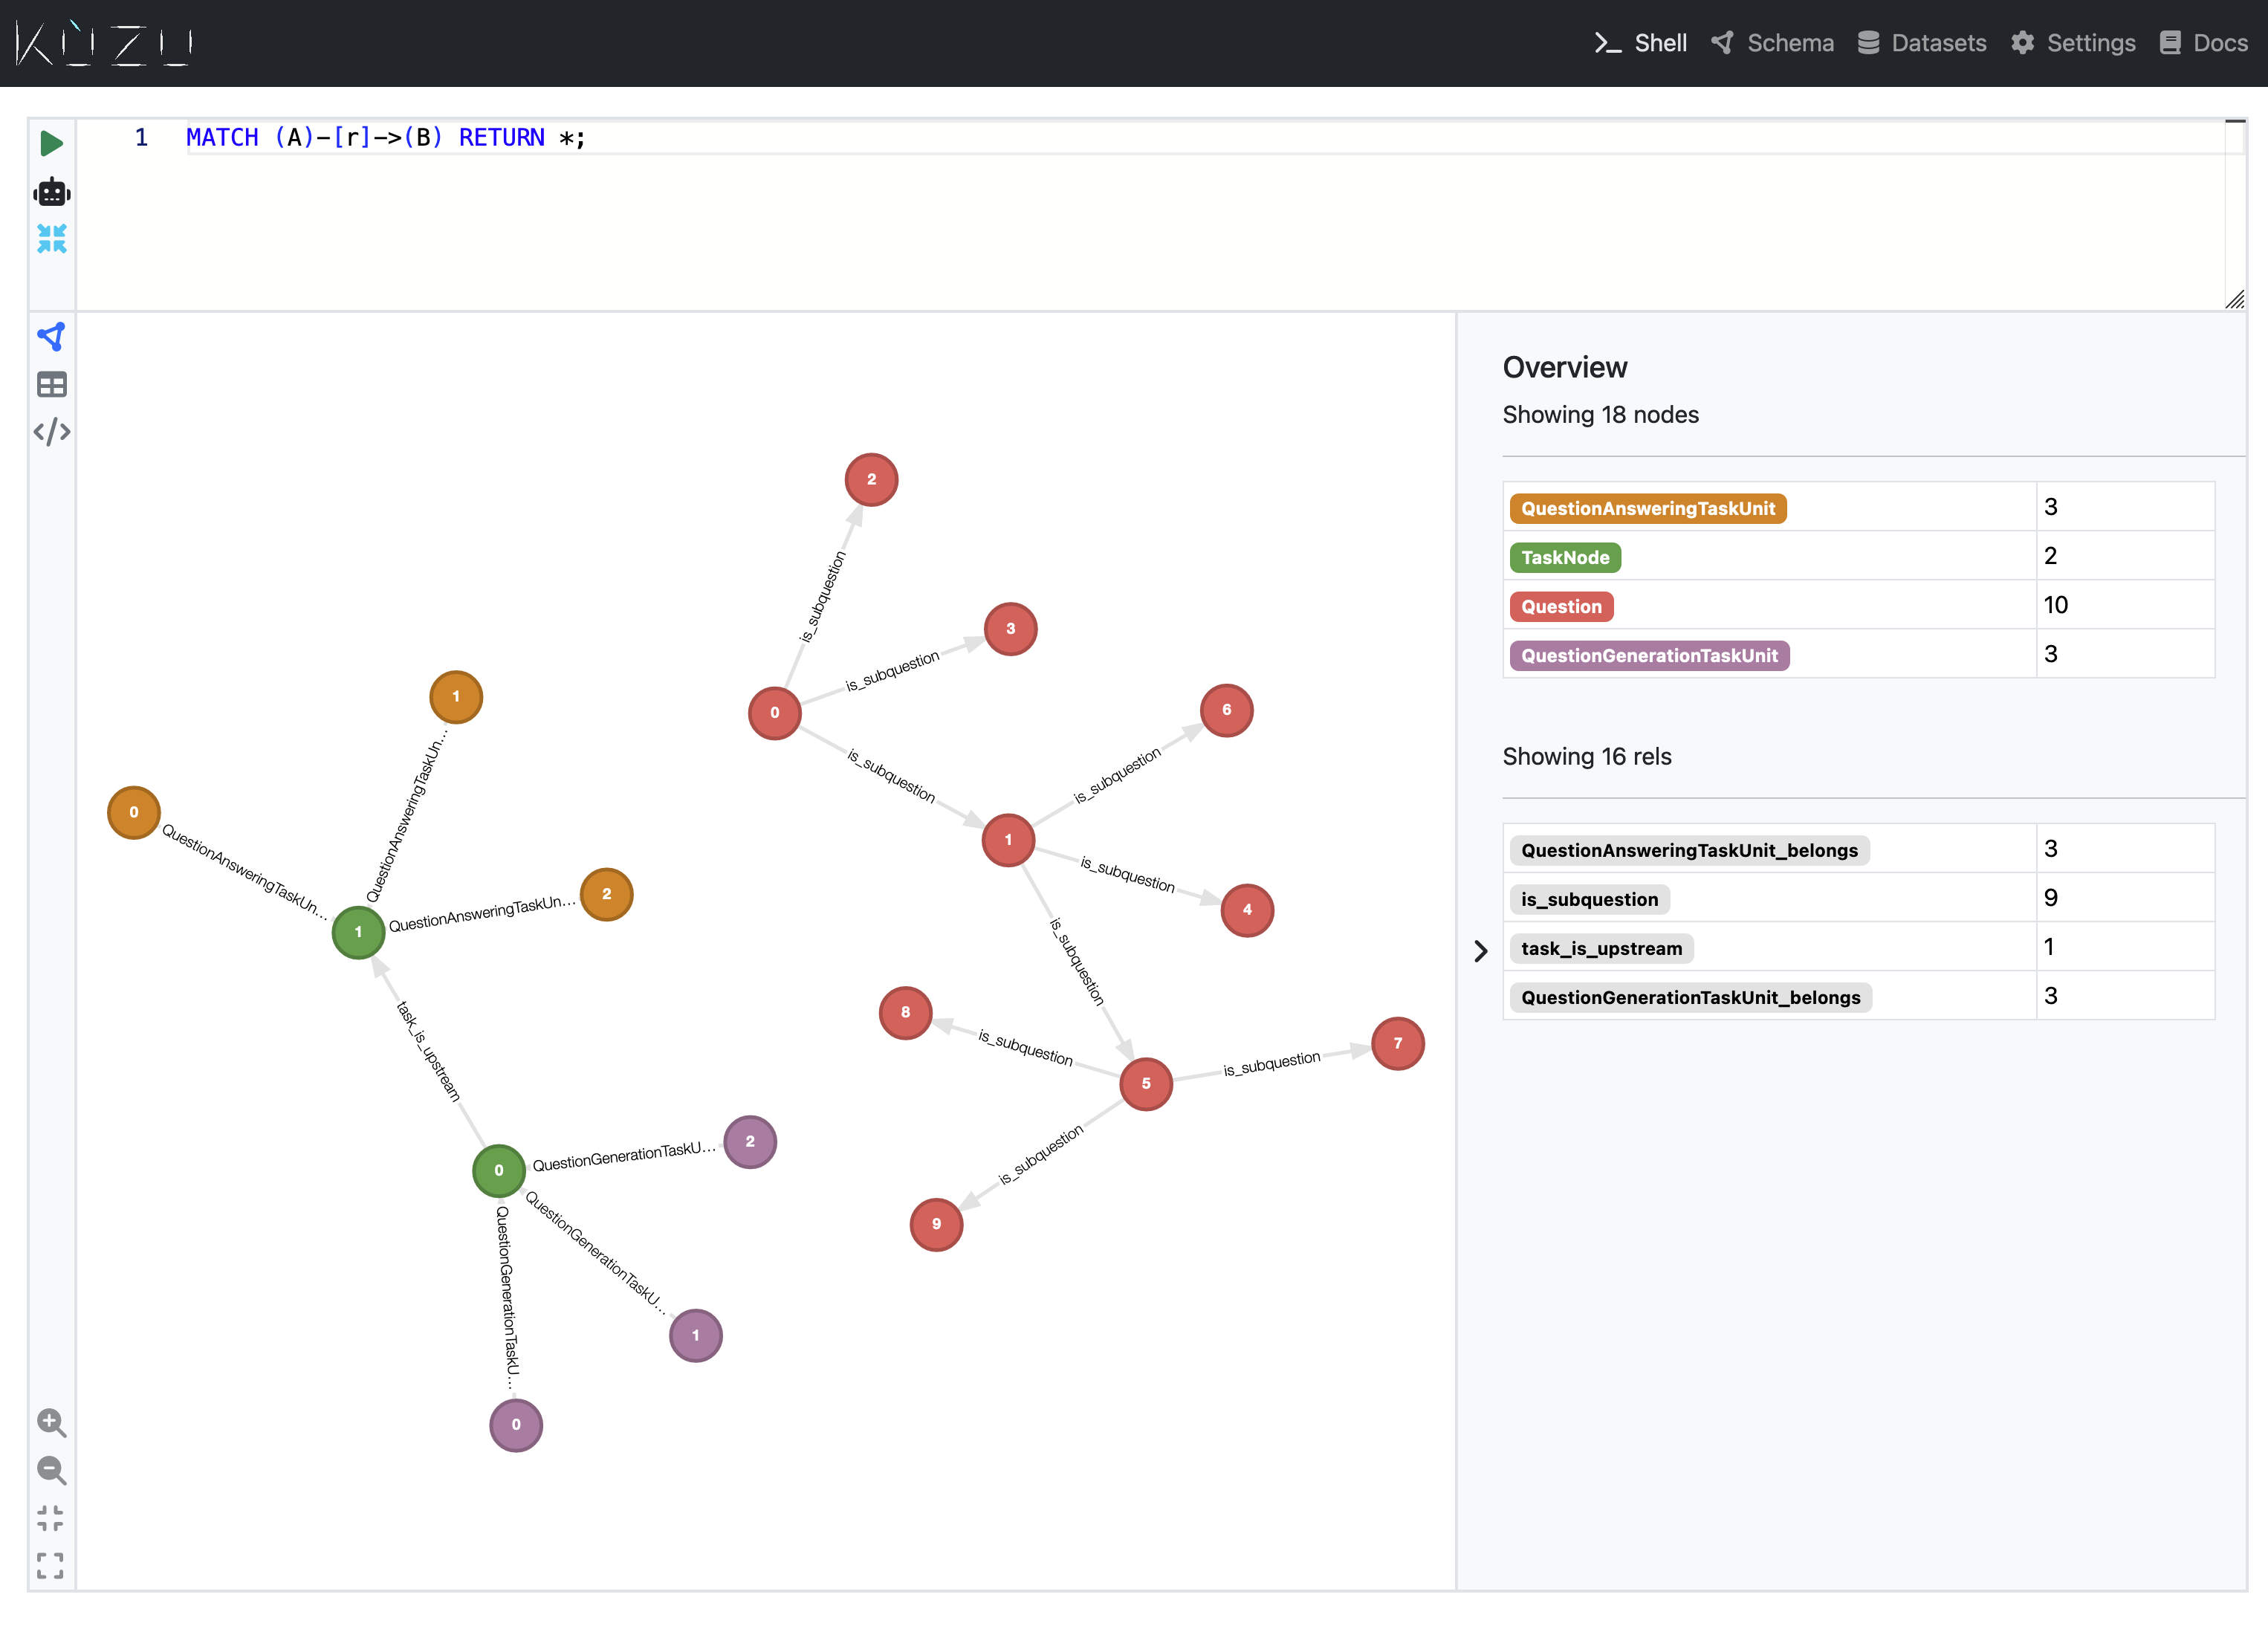